# Evaluation of Spec2Vec Annotations by comparing it to manual MotifDB Annotations

In [106]:
import json
import os
print(os.getcwd())

import numpy as np
import matplotlib.pyplot as plt 

C:\Users\dietr004\Documents\PhD\computational mass spectrometry\WP1\MS2LDA\notebooks\Paper_results


## Load Manual and Automatic Annotation

#### Urine derived dataset

In [107]:
# manual annotation 
path_manual_annotation_urine = "Annotation_Benchmark_MotifSets/Urine_manual_annotation_pos.json"
with open(path_manual_annotation_urine, "r") as injson: manual_annotation_urine = json.load(injson)

In [108]:
# automated annotation
path_spec2vec_annotation_urine = "Annotation_Benchmark_MotifSets/Urine derived Mass2Motifs.json"
with open(path_spec2vec_annotation_urine, "r") as injson: spec2vec_annotation_urine = json.load(injson)

In [109]:
# automated annotation
path_spec2vec_annotation_urine = "Annotation_Benchmark_MotifSets/Urine_auto_annotation_pos.json"
with open(path_spec2vec_annotation_urine, "r") as injson: spec2vec_annotation_urine = json.load(injson)

#### Massbank derived dataset

In [110]:
# manual annotation
path_manual_annotation_massbank = "Annotation_Benchmark_MotifSets/MassBank_manual_annotation_pos.json"
with open(path_manual_annotation_massbank, "r") as injson: manual_annotation_massbank = json.load(injson)

In [111]:
# automated annotation
path_spec2vec_annotation_massbank = "Annotation_Benchmark_MotifSets/Massbank library derived Mass2Motifs.json"
with open(path_spec2vec_annotation_massbank, "r") as injson: spec2vec_annotation_massbank = json.load(injson)

In [112]:
# automated annotation
path_spec2vec_annotation_massbank = "Annotation_Benchmark_MotifSets/MassBank_auto_annotation_pos.json"
with open(path_spec2vec_annotation_massbank, "r") as injson: spec2vec_annotation_massbank = json.load(injson)

#### GNPS derived Motifset

In [113]:
# manual annotation
path_manual_annotation_gnps = "Annotation_Benchmark_MotifSets/GNPS_manual_annotation_pos.json"
with open(path_manual_annotation_gnps, "r") as injson: manual_annotation_gnps = json.load(injson)

In [114]:
# automated annotation
path_spec2vec_annotation_gnps = "Annotation_Benchmark_MotifSets/GNPS library derived Mass2Motifs.json" 
with open(path_spec2vec_annotation_gnps, "r") as injson: spec2vec_annotation_gnps = json.load(injson)

In [115]:
# automated annotation
path_spec2vec_annotation_gnps = "Annotation_Benchmark_MotifSets/GNPS_auto_annotation_pos.json" 
with open(path_spec2vec_annotation_gnps, "r") as injson: spec2vec_annotation_gnps = json.load(injson)

## Extract Mass2MotifIDs having manual and automated annotation

In [116]:
def intersection_manual_and_automated_annotations(automated_annotations: dict, manual_annotations: dict) -> list:
    """not for all Mass2Motifs were manually or automatically annotated:
    - extremly small substructure (CO2 loss and acetyl-loss): not manually annotated
    - annotation with no matching compound in pubchem based on name: not manually annotated
    - motifs consisting only of losses: not automatically annotated

    For the comparison we use the intersection of the manually and automatically annotated Mass2motifs
    """

    fully_annotated_Mass2Motifs = []
    for Mass2MotifID in automated_annotations.keys():
        if Mass2MotifID in manual_annotations.keys():
            if manual_annotations[Mass2MotifID]["SMILES"]: 
                fully_annotated_Mass2Motifs.append(Mass2MotifID)
            
    return fully_annotated_Mass2Motifs

In [117]:
urine_fully_annotated_Mass2MotifIDs = intersection_manual_and_automated_annotations(spec2vec_annotation_urine, manual_annotation_urine)
print("Number of Mass2Motifs with automated and manual annotation (Urine): ", len(urine_fully_annotated_Mass2MotifIDs))

Number of Mass2Motifs with automated and manual annotation (Urine):  83


In [118]:
massbank_fully_annotated_Mass2MotifIDs = intersection_manual_and_automated_annotations(spec2vec_annotation_massbank, manual_annotation_massbank)
print("Number of Mass2Motifs with automated and manual annotation (Massbank): ", len(massbank_fully_annotated_Mass2MotifIDs))

Number of Mass2Motifs with automated and manual annotation (Massbank):  27


In [119]:
gnps_fully_annotated_Mass2MotifIDs = intersection_manual_and_automated_annotations(spec2vec_annotation_gnps, manual_annotation_gnps)
print("Number of Mass2Motifs with automated and manual annotation (GNPS): ", len(gnps_fully_annotated_Mass2MotifIDs))

Number of Mass2Motifs with automated and manual annotation (GNPS):  66


## Extract smiles and calculate substructure fingerprints

In [120]:
from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as substrucFP

In [121]:
def compute_fps_for_fully_annotated_Mass2Motifs(fully_annotated_Mass2MotifIDs, manual_annotations, automated_annotations, fp_type):
    """
    """
    manual_smiles_lists = []
    automated_smiles_lists = []
    for Mass2MotifID in fully_annotated_Mass2MotifIDs:
        manual_smiles_lists.append(manual_annotations[Mass2MotifID]["SMILES"])
        automated_smiles_lists.append(automated_annotations[Mass2MotifID]["SMILES"])

    manual_substructure_fps = substrucFP(manual_smiles_lists, fp_type=fp_type, threshold=0.9)
    automated_substructure_fps = substrucFP(automated_smiles_lists, fp_type=fp_type, threshold=0.9)

    return manual_substructure_fps, automated_substructure_fps 

In [122]:
# urine substructure fingerprints
urine_manual_substructure_maccs, urine_automated_substructure_maccs = compute_fps_for_fully_annotated_Mass2Motifs(urine_fully_annotated_Mass2MotifIDs, manual_annotation_urine, spec2vec_annotation_urine, "maccs")
urine_manual_substructure_rdkit, urine_automated_substructure_rdkit = compute_fps_for_fully_annotated_Mass2Motifs(urine_fully_annotated_Mass2MotifIDs, manual_annotation_urine, spec2vec_annotation_urine, "rdkit")

In [123]:
# massbank substructure fingerprints
massbank_manual_substructure_maccs, massbank_automated_substructure_maccs = compute_fps_for_fully_annotated_Mass2Motifs(massbank_fully_annotated_Mass2MotifIDs, manual_annotation_massbank, spec2vec_annotation_massbank, "maccs")
massbank_manual_substructure_rdkit, massbank_automated_substructure_rdkit = compute_fps_for_fully_annotated_Mass2Motifs(massbank_fully_annotated_Mass2MotifIDs, manual_annotation_massbank, spec2vec_annotation_massbank, "rdkit")

In [124]:
# gnps substructure fingerprints
gnps_manual_substructure_maccs, gnps_automated_substructure_maccs = compute_fps_for_fully_annotated_Mass2Motifs(gnps_fully_annotated_Mass2MotifIDs, manual_annotation_gnps, spec2vec_annotation_gnps, "maccs")
gnps_manual_substructure_rdkit, gnps_automated_substructure_rdkit = compute_fps_for_fully_annotated_Mass2Motifs(gnps_fully_annotated_Mass2MotifIDs, manual_annotation_gnps, spec2vec_annotation_gnps, "rdkit")

## Substructure Overlap Score (sos)

In [125]:
def calculate_sos(fp1, fp2):
    if sum(fp1) < sum(fp2):
        smaller_fp = fp1
        bigger_fp = fp2
    else:
        smaller_fp = fp2
        bigger_fp = fp1
    
    smaller_fp_sum = sum(smaller_fp)
    fp_intersection = 0
    for bit1, bit2 in zip(smaller_fp, bigger_fp):
        if bit1 == 1 and bit2 == 1:
            fp_intersection += 1

    if fp_intersection == 0:
        return 0
    else:
        return fp_intersection / smaller_fp_sum

In [126]:
urine_substructure_overlap_scores_maccs = [calculate_sos(urine_manual_substructure_fp, urine_automated_substructure_fp) for urine_manual_substructure_fp, urine_automated_substructure_fp in zip(urine_manual_substructure_maccs, urine_automated_substructure_maccs)]
urine_median_sos_maccs = np.median(urine_substructure_overlap_scores_maccs)
urine_average_sos_maccs = np.average(urine_substructure_overlap_scores_maccs)
print("Median SOS (Urine): ", urine_median_sos_maccs)
print("Average SOS (Urine): ", urine_average_sos_maccs)

Median SOS (Urine):  0.8421052631578947
Average SOS (Urine):  0.759143158866012


In [127]:
massbank_substructure_overlap_scores_maccs = [calculate_sos(massbank_manual_substructure_fp, massbank_automated_substructure_fp) for massbank_manual_substructure_fp, massbank_automated_substructure_fp in zip(massbank_manual_substructure_maccs, massbank_automated_substructure_maccs)]
massbank_median_sos_maccs = np.median(massbank_substructure_overlap_scores_maccs)
massbank_average_sos_maccs = np.average(massbank_substructure_overlap_scores_maccs)
print("Median SOS (Massbank): ", massbank_median_sos_maccs)
print("Average SOS (Massbank): ", massbank_average_sos_maccs)

Median SOS (Massbank):  0.9285714285714286
Average SOS (Massbank):  0.7552836207555443


In [128]:
gnps_substructure_overlap_scores_maccs = [calculate_sos(gnps_manual_substructure_fp, gnps_automated_substructure_fp) for gnps_manual_substructure_fp, gnps_automated_substructure_fp in zip(gnps_manual_substructure_maccs, gnps_automated_substructure_maccs)]
gnps_median_sos_maccs = np.median(gnps_substructure_overlap_scores_maccs)
gnps_average_sos_maccs = np.average(gnps_substructure_overlap_scores_maccs)
print("Median SOS (GNPS): ", gnps_median_sos_maccs)
print("Average SOS (GNPS): ", gnps_average_sos_maccs)

Median SOS (GNPS):  0.8556547619047619
Average SOS (GNPS):  0.8234550228829145


In [129]:
urine_substructure_overlap_scores_rdkit = [calculate_sos(urine_manual_substructure_fp, urine_automated_substructure_fp) for urine_manual_substructure_fp, urine_automated_substructure_fp in zip(urine_manual_substructure_rdkit, urine_automated_substructure_rdkit)]
urine_median_sos_rdkit = np.median(urine_substructure_overlap_scores_rdkit)
urine_average_sos_rdkit = np.average(urine_substructure_overlap_scores_rdkit)
print("Median SOS (Urine): ", urine_median_sos_rdkit)
print("Average SOS (Urine): ", urine_average_sos_rdkit)

Median SOS (Urine):  0.6578947368421053
Average SOS (Urine):  0.6264197562690859


In [130]:
massbank_substructure_overlap_scores_rdkit = [calculate_sos(massbank_manual_substructure_fp, massbank_automated_substructure_fp) for massbank_manual_substructure_fp, massbank_automated_substructure_fp in zip(massbank_manual_substructure_rdkit, massbank_automated_substructure_rdkit)]
massbank_median_sos_rdkit = np.median(massbank_substructure_overlap_scores_rdkit)
massbank_average_sos_rdkit = np.average(massbank_substructure_overlap_scores_rdkit)
print("Median SOS (Massbank): ", massbank_median_sos_rdkit)
print("Average SOS (Massbank): ", massbank_average_sos_rdkit)

Median SOS (Massbank):  0.8205128205128205
Average SOS (Massbank):  0.6851092567195328


In [131]:
gnps_substructure_overlap_scores_rdkit = [calculate_sos(gnps_manual_substructure_fp, gnps_automated_substructure_fp) for gnps_manual_substructure_fp, gnps_automated_substructure_fp in zip(gnps_manual_substructure_rdkit, gnps_automated_substructure_rdkit)]
gnps_median_sos_rdkit = np.median(gnps_substructure_overlap_scores_rdkit)
gnps_average_sos_rdkit = np.average(gnps_substructure_overlap_scores_rdkit)
print("Median SOS (GNPS): ", gnps_median_sos_rdkit)
print("Average SOS (GNPS): ", gnps_average_sos_rdkit)

Median SOS (GNPS):  0.8562789098637329
Average SOS (GNPS):  0.7504077985149112


## Visualization

In [132]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [133]:
def sos_histplot(substructure_overlap_scores, median_score, average_score, color, fp_type, savepath=None):
    font = {'family' : 'Times New Roman',
            'size'   : 15}
    matplotlib.rc('font', **font)
    sns.set_context("paper")  # Set context to 'paper' for publication-like aesthetics
    sns.set_style("white")    # Clean background
    
    fig, ax = plt.subplots(1,1, layout="constrained", figsize=(10,2.5), sharex=True)
    
    ax.hist(substructure_overlap_scores, bins=20, color=color, alpha=0.8, label="Overlap Score")  # Black bars with dark gray edges
    ax.text(0.01,8,f"\n Median: {round(median_score,2)} \n Mean: {round(average_score,2)}", fontsize=15)
    ax.set_xlabel(f"{fp_type} Fingerprint based Substructure Overlap (%)", fontsize=15)
    ax.set_ylabel("n Mass2Motifs", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    ax.set_xlim(left=0)  # Ensure x-axis starts at 0
    ax.set_ylim(bottom=0)  # Ensure y-axis starts at 0
    plt.legend(prop = {"size":15})
    if savepath != None:
        plt.savefig(save, dpi=1440, bbox_inches='tight')
    return fig

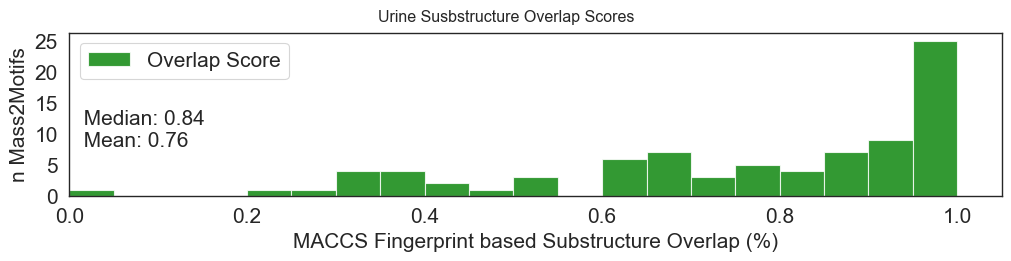

In [134]:
sos_histplot(urine_substructure_overlap_scores_maccs, median_score=urine_median_sos_maccs, average_score=urine_average_sos_maccs, color="green", fp_type="MACCS").suptitle("Urine Susbstructure Overlap Scores")
plt.show()

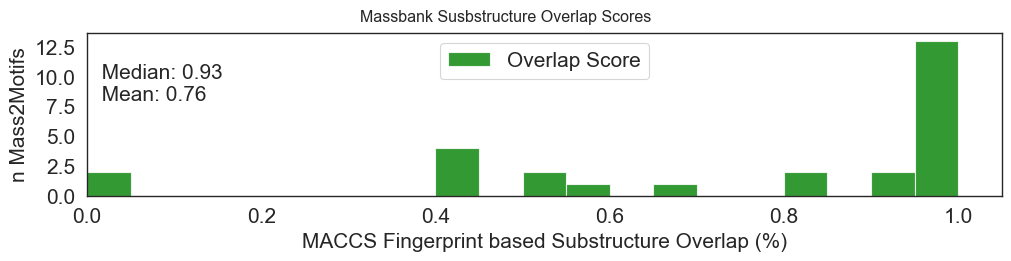

In [135]:
sos_histplot(massbank_substructure_overlap_scores_maccs, median_score=massbank_median_sos_maccs, average_score=massbank_average_sos_maccs, color="green", fp_type="MACCS").suptitle("Massbank Susbstructure Overlap Scores")
plt.show()

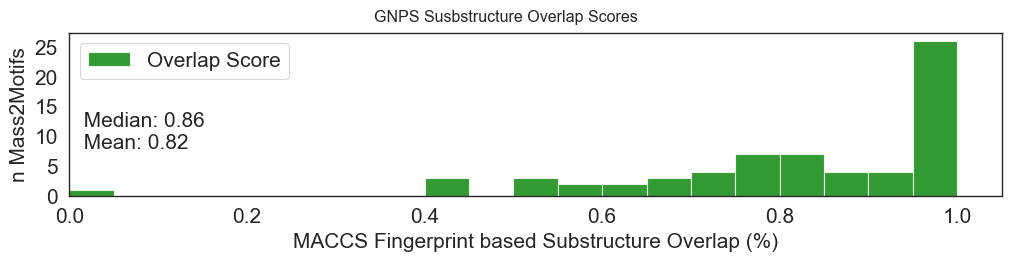

In [136]:
sos_histplot(gnps_substructure_overlap_scores_maccs, median_score=gnps_median_sos_maccs, average_score=gnps_average_sos_maccs, color="green", fp_type="MACCS").suptitle("GNPS Susbstructure Overlap Scores")
plt.show()

---

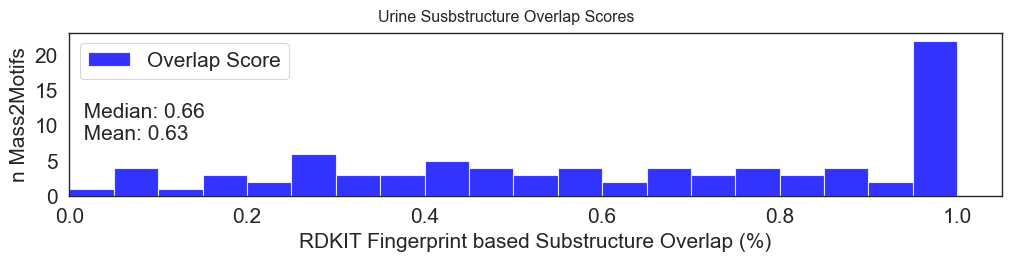

In [137]:
sos_histplot(urine_substructure_overlap_scores_rdkit, median_score=urine_median_sos_rdkit, average_score=urine_average_sos_rdkit, color="blue", fp_type="RDKIT").suptitle("Urine Susbstructure Overlap Scores")
plt.show()

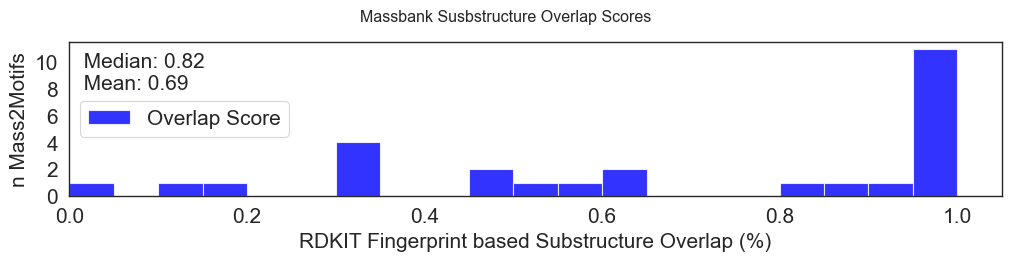

In [138]:
sos_histplot(massbank_substructure_overlap_scores_rdkit, median_score=massbank_median_sos_rdkit, average_score=massbank_average_sos_rdkit, color="blue", fp_type="RDKIT").suptitle("Massbank Susbstructure Overlap Scores")
plt.show()

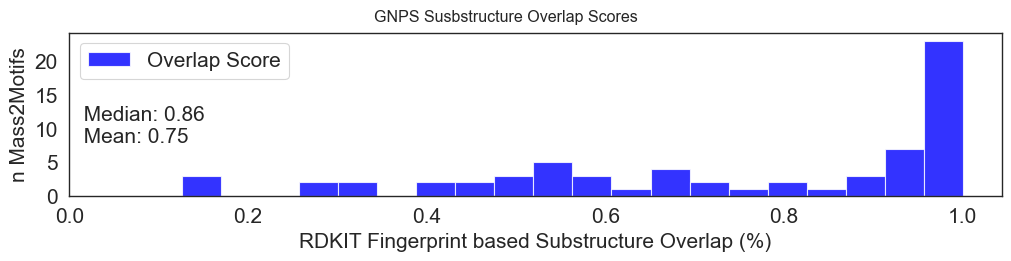

In [139]:
sos_histplot(gnps_substructure_overlap_scores_rdkit, median_score=gnps_median_sos_rdkit, average_score=gnps_average_sos_rdkit, color="blue", fp_type="RDKIT").suptitle("GNPS Susbstructure Overlap Scores")
plt.show()

## Urine dataset examples

In [140]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Draw import MolsToGridImage
from rdkit import Chem
from rdkit.Chem import Draw

### Perfect Example

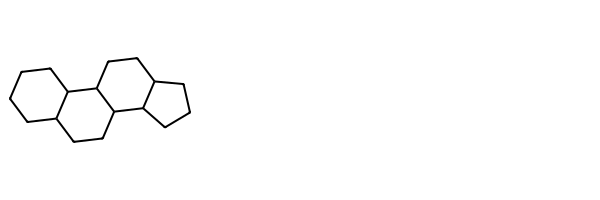

In [141]:
# Manual Annotation
MolsToGridImage([MolFromSmiles(smi) for smi in manual_annotation_gnps["gnps_motif_115.m2m"]["SMILES"]])

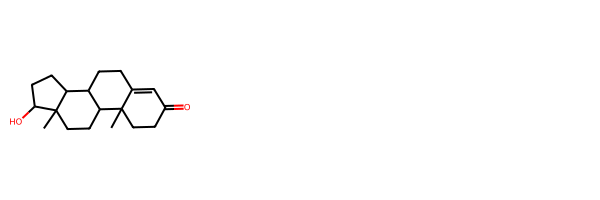

In [142]:
# Automated Annotation
MolsToGridImage([MolFromSmiles(smi) for smi in  spec2vec_annotation_gnps["gnps_motif_115.m2m"]["SMILES"]])

In [143]:
perfect_example_index = gnps_fully_annotated_Mass2MotifIDs.index("gnps_motif_115.m2m")
print("Manual description: ",manual_annotation_gnps["gnps_motif_115.m2m"]["ANNOTATION"])
print("MACCS based SOS: ", gnps_substructure_overlap_scores_maccs[perfect_example_index])
print("RDKit based SOS: ", gnps_substructure_overlap_scores_rdkit[perfect_example_index])

Manual description:  Sterone steroid related
MACCS based SOS:  1.0
RDKit based SOS:  1.0


### Medium Example

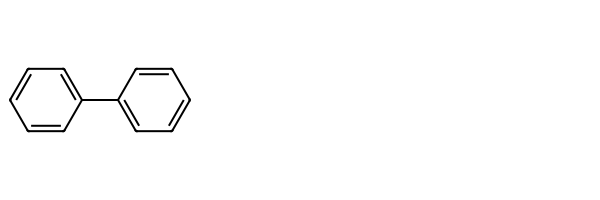

In [144]:
# Manual Annotation
MolsToGridImage([MolFromSmiles(smi) for smi in manual_annotation_gnps["gnps_motif_6.m2m"]["SMILES"]])

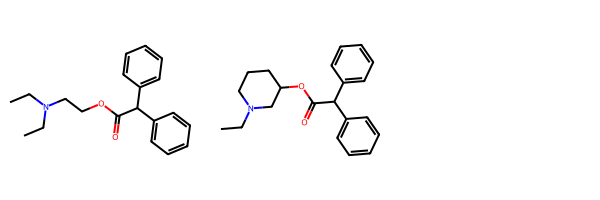

In [145]:
# Automated Annotation
MolsToGridImage([MolFromSmiles(smi) for smi in  spec2vec_annotation_gnps["gnps_motif_6.m2m"]["SMILES"]])

In [146]:
medium_example_index = gnps_fully_annotated_Mass2MotifIDs.index("gnps_motif_6.m2m")
print("Manual description: ",manual_annotation_gnps["gnps_motif_37.m2m"]["ANNOTATION"])
print("MACCS based SOS: ", gnps_substructure_overlap_scores_maccs[medium_example_index])
print("RDKit based SOS: ", gnps_substructure_overlap_scores_rdkit[medium_example_index])

Manual description:  Fragments indicative for cinnamic/hydroxycinnamic acid substructure
MACCS based SOS:  0.8333333333333334
RDKit based SOS:  0.3194444444444444


### Bad Example

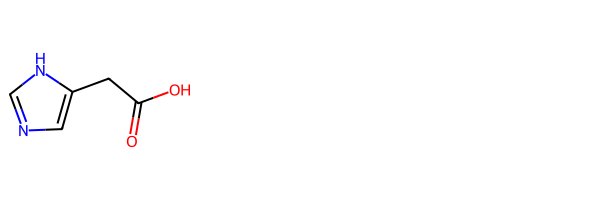

In [147]:
# Manual Annotation
MolsToGridImage([MolFromSmiles(smi) for smi in manual_annotation_gnps["gnps_motif_53.m2m"]["SMILES"]])

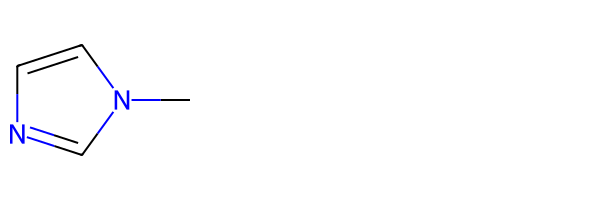

In [148]:
# Automated Annotation
MolsToGridImage([MolFromSmiles(smi) for smi in  spec2vec_annotation_gnps["gnps_motif_53.m2m"]["SMILES"]])

In [150]:
bad_example_index = gnps_fully_annotated_Mass2MotifIDs.index("gnps_motif_53.m2m")
print("Manual description: ",manual_annotation_gnps["gnps_motif_53.m2m"]["ANNOTATION"])
print("MACCS based SOS: ", gnps_substructure_overlap_scores_maccs[bad_example_index])
print("RDKit based SOS: ", gnps_substructure_overlap_scores_rdkit[bad_example_index])

Manual description:  Imidazole group linked to a carboxylgroup through one CH2 group i.e. like in imidazole acetic acid
MACCS based SOS:  0.631578947368421
RDKit based SOS:  0.49056603773584906
